In [1]:
from datetime import datetime

def hours_until(hour, pm=True):
    """
    hour: int (1–12)
    pm: bool (True for PM, False for AM)
    returns: float, number of hours from now until that time today
    """
    now = datetime.now()
    hour_24 = hour % 12 + (12 if pm else 0)
    target = datetime(now.year, now.month, now.day, hour_24, 0, 0)
    
    # If target time has already passed today, assume tomorrow
    if target < now:
        target = target.replace(day=now.day + 1)
    
    delta = target - now
    return delta.total_seconds() / 3600  # Convert seconds to hours

# Example usage
print("Hours until 11 PM:", hours_until(11, pm=True))
print("Hours until 7 AM:", hours_until(7, pm=False))

Hours until 11 PM: 20.14440076138889
Hours until 7 AM: 4.144400761388889


In [64]:
from scipy.stats import norm
import numpy as np
import json

def binary_call_price(S, K, T, sigma, r=0.0):
    d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    price = np.exp(-r * T) * norm.cdf(d2)
    return price


In [89]:
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np

# Function to solve: theoretical price - market price = 0
def implied_vol_binary_call(S, K, tte, market_price, r=0.0):
    def objective(sigma):
        return binary_call_price(S, K, tte, sigma, r) - market_price

    try:
        return brentq(objective, 1e-6, 500000.0, xtol=0.01)  # Search for sigma in [0.001, 500%]
    except ValueError:
        return np.nan  # No solution found in the interval


In [90]:
underlying = 94478
strike = 125000
bid = 0.50
ask = 0.49

hours_in_year = 365 * 24

tte = 5959 / hours_in_year  # Time to expiration in years

ask_iv = implied_vol_binary_call(underlying, strike, tte, ask)
bid_iv = implied_vol_binary_call(underlying, strike, tte, bid)

ask_iv, bid_iv

(nan, nan)

In [102]:
def binary_call_upper_bound(T, r=0.0):
    discount_factor = np.exp(-r * T)
    upper_bound_price = 0.5 * discount_factor
    return upper_bound_price

Theoretical Upper Bound: 0.4885


C:\Users\chris\AppData\Local\Temp\ipykernel_19712\3943419210.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


Text(0.5, 1.0, 'Binary Call Price vs Implied Volatility')

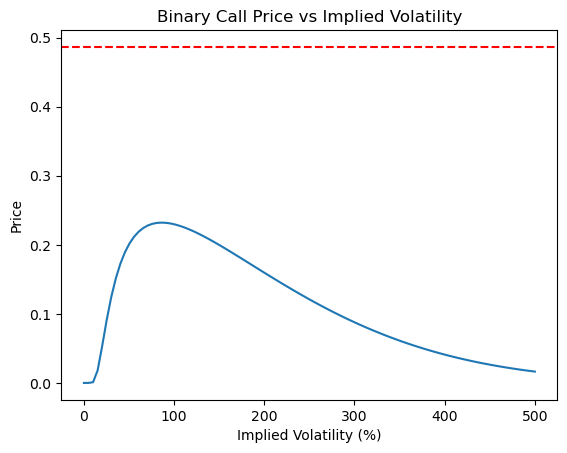

In [103]:
import matplotlib.pyplot as plt
ivs = np.linspace(0, 5, 100)

prices = [binary_call_price(underlying, strike, tte, iv, 0.04) for iv in ivs]

# Example usage:
T = 7/12  # 7 months
r = 0.04  # 4% risk-free rate

print(f"Theoretical Upper Bound: {binary_call_upper_bound(T, r):.4f}")


plt.plot(ivs*100, prices)
plt.axhline(y=binary_call_upper_bound(tte, 0.04), color='r', linestyle='--', label='Upper Bound')
plt.xlabel('Implied Volatility (%)')
plt.ylabel('Price')
plt.title('Binary Call Price vs Implied Volatility')

In [115]:
from scipy.stats import norm
import numpy as np

def one_touch_up_price(S, K, T, sigma, r=0.0):
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return np.nan  # sanity check for inputs

    # Calculate parameters
    lambda_ = (r / sigma**2) + 0.5
    d1_prime = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2_prime = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    # One-touch price
    term1 = (S / K) ** (2 * lambda_) * norm.cdf(d1_prime)
    term2 = norm.cdf(d2_prime)
    
    price = np.exp(-r * T) * (term1 + term2)
    
    return price

from scipy.optimize import brentq

def implied_vol_one_touch(S, K, T, r, market_price, sigma_lower=1e-6, sigma_upper=5.0):
    def objective(sigma):
        model_price = one_touch_up_price(S, K, T, sigma, r)
        return model_price - market_price

    try:
        implied_vol = brentq(objective, sigma_lower, sigma_upper, xtol=1e-6)
        return implied_vol
    except ValueError:
        return np.nan  # No solution found



In [124]:
S = 100000
K = 125000
T = tte
r = 0.04
market_touch_price = 0.50  # Suppose you observe 50¢ for the touch binary

implied_sigma = implied_vol_one_touch(S, K, T, r, market_touch_price)
print(f"Implied Volatility for One-Touch: {implied_sigma:.4f}")

Implied Volatility for One-Touch: 0.4604


In [96]:
import requests

session = requests.Session()

def get_brti_price():
    try:
        response = session.get("http://localhost:5000/price", timeout=0.2)
        if response.status_code == 200:
            data = response.json()
            return data['brti'], data['simple_average'], data['timestamp']
        else:
            print("⚠️ Server responded with:", response.status_code)
            return None, None
    except requests.exceptions.RequestException as e:
        print("❌ Error fetching price:", e)
        return None, None

In [97]:
import requests
import json


url = "https://api.elections.kalshi.com/trade-api/v2/markets"

params = {
    "series_ticker" : 'KXBTCD'
}

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers, params=params)

markets = json.loads(response.text)['markets']


In [98]:
markets[0]

{'ticker': 'KXBTCD-25APR2817-T99999.99',
 'event_ticker': 'KXBTCD-25APR2817',
 'market_type': 'binary',
 'title': 'Bitcoin price  on Apr 28, 2025?',
 'subtitle': '$100,000 or above',
 'yes_sub_title': '$100,000 or above',
 'no_sub_title': '$100,000 or above',
 'open_time': '2025-04-27T20:00:00Z',
 'close_time': '2025-04-28T21:00:00Z',
 'expected_expiration_time': '2025-04-28T21:05:00Z',
 'expiration_time': '2025-05-05T21:00:00Z',
 'latest_expiration_time': '2025-05-05T21:00:00Z',
 'settlement_timer_seconds': 60,
 'status': 'active',
 'response_price_units': 'usd_cent',
 'notional_value': 100,
 'tick_size': 1,
 'yes_bid': 0,
 'yes_ask': 35,
 'no_bid': 65,
 'no_ask': 100,
 'last_price': 0,
 'previous_yes_bid': 0,
 'previous_yes_ask': 0,
 'previous_price': 0,
 'volume': 0,
 'volume_24h': 0,
 'liquidity': 6361548,
 'open_interest': 0,
 'result': '',
 'can_close_early': True,
 'expiration_value': '',
 'category': '',
 'risk_limit_cents': 0,
 'strike_type': 'greater',
 'floor_strike': 99999.

In [99]:
import requests


url = "https://api.elections.kalshi.com/trade-api/v2/markets?limit=500&series_ticker=KXBTCD&status=open"

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)

markets = json.loads(response.text)

print(len(markets['markets']))

for m in markets['markets']:
    print(m['ticker'])

165
KXBTCD-25APR2817-T99999.99
KXBTCD-25APR2817-T99499.99
KXBTCD-25APR2817-T98999.99
KXBTCD-25APR2817-T98499.99
KXBTCD-25APR2817-T103499.99
KXBTCD-25APR2817-T102999.99
KXBTCD-25APR2817-T102499.99
KXBTCD-25APR2817-T101999.99
KXBTCD-25APR2817-T101499.99
KXBTCD-25APR2817-T100999.99
KXBTCD-25APR2817-T100499.99
KXBTCD-25APR2817-T97999.99
KXBTCD-25APR2817-T97499.99
KXBTCD-25APR2817-T96999.99
KXBTCD-25APR2817-T96499.99
KXBTCD-25APR2817-T95999.99
KXBTCD-25APR2817-T95499.99
KXBTCD-25APR2817-T94999.99
KXBTCD-25APR2817-T94499.99
KXBTCD-25APR2817-T93999.99
KXBTCD-25APR2817-T93499.99
KXBTCD-25APR2817-T92999.99
KXBTCD-25APR2817-T92499.99
KXBTCD-25APR2817-T91999.99
KXBTCD-25APR2817-T91499.99
KXBTCD-25APR2817-T90999.99
KXBTCD-25APR2817-T90499.99
KXBTCD-25APR2817-T89999.99
KXBTCD-25APR2817-T89499.99
KXBTCD-25APR2817-T88999.99
KXBTCD-25APR2817-T88499.99
KXBTCD-25APR2817-T87999.99
KXBTCD-25APR2817-T87499.99
KXBTCD-25APR2817-T86999.99
KXBTCD-25APR2817-T86499.99
KXBTCD-25APR2817-T85999.99
KXBTCD-25APR2817-

In [100]:
price = 94000

threshold = 350

In [101]:
for contract in markets:
    
    strike = np.round(contract['floor_strike'])
    if abs(strike - price) < threshold:
        print(strike)

TypeError: string indices must be integers, not 'str'

In [102]:
for market in json.loads(response.text)['markets']:
    print(market['ticker'])



KXBTCD-25APR2817-T99999.99
KXBTCD-25APR2817-T99499.99
KXBTCD-25APR2817-T98999.99
KXBTCD-25APR2817-T98499.99
KXBTCD-25APR2817-T103499.99
KXBTCD-25APR2817-T102999.99
KXBTCD-25APR2817-T102499.99
KXBTCD-25APR2817-T101999.99
KXBTCD-25APR2817-T101499.99
KXBTCD-25APR2817-T100999.99
KXBTCD-25APR2817-T100499.99
KXBTCD-25APR2817-T97999.99
KXBTCD-25APR2817-T97499.99
KXBTCD-25APR2817-T96999.99
KXBTCD-25APR2817-T96499.99
KXBTCD-25APR2817-T95999.99
KXBTCD-25APR2817-T95499.99
KXBTCD-25APR2817-T94999.99
KXBTCD-25APR2817-T94499.99
KXBTCD-25APR2817-T93999.99
KXBTCD-25APR2817-T93499.99
KXBTCD-25APR2817-T92999.99
KXBTCD-25APR2817-T92499.99
KXBTCD-25APR2817-T91999.99
KXBTCD-25APR2817-T91499.99
KXBTCD-25APR2817-T90999.99
KXBTCD-25APR2817-T90499.99
KXBTCD-25APR2817-T89999.99
KXBTCD-25APR2817-T89499.99
KXBTCD-25APR2817-T88999.99
KXBTCD-25APR2817-T88499.99
KXBTCD-25APR2817-T87999.99
KXBTCD-25APR2817-T87499.99
KXBTCD-25APR2817-T86999.99
KXBTCD-25APR2817-T86499.99
KXBTCD-25APR2817-T85999.99
KXBTCD-25APR2817-T854

In [ ]:
def get_orderbook(ticker, cents=True):    
    try: 
        url = f"https://api.elections.kalshi.com/trade-api/v2/markets/{ticker}/orderbook"
        headers = {"accept": "application/json"}
        response = requests.get(url, headers=headers)
        order_book = json.loads(response.text)['orderbook']

    except Exception as e:
        print("❌ Error fetching orderbook:", e)
        return None, None

TypeError: string indices must be integers, not 'str'

In [ ]:
def get_chain(event, brti_price=0, threshold=1000):
    try:
        url = "https://api.elections.kalshi.com/trade-api/v2/events/{event}"
        headers = {"accept": "application/json"}
        response = requests.get(url, headers=headers)

        chain = []
        for m in json.loads(response.text)['markets']:
            strike = (round(m['floor_strike'], 0))

            if abs(strike - binary_call_price) < threshold:
                chain.append(m)

        return chain    
    except Exception as e:
        print("❌ Error fetching chain:", e)
        return None, None

In [143]:
url = "https://api.elections.kalshi.com/trade-api/v2/events/KXBTCD-25APR2719"
headers = {"accept": "application/json"}
response = requests.get(url, headers=headers)


json.loads(response.text)['markets'][50]

{'ticker': 'KXBTCD-25APR2719-T97499.99',
 'event_ticker': 'KXBTCD-25APR2719',
 'market_type': 'binary',
 'title': '',
 'subtitle': '$97,500 or above',
 'yes_sub_title': '$97,500 or above',
 'no_sub_title': '$97,500 or above',
 'open_time': '2025-04-27T22:00:00Z',
 'close_time': '2025-04-27T23:00:00Z',
 'expected_expiration_time': '2025-04-27T23:05:00Z',
 'expiration_time': '2025-05-04T23:00:00Z',
 'latest_expiration_time': '2025-05-04T23:00:00Z',
 'settlement_timer_seconds': 60,
 'status': 'active',
 'response_price_units': 'usd_cent',
 'notional_value': 100,
 'tick_size': 1,
 'yes_bid': 0,
 'yes_ask': 29,
 'no_bid': 71,
 'no_ask': 100,
 'last_price': 0,
 'previous_yes_bid': 0,
 'previous_yes_ask': 0,
 'previous_price': 0,
 'volume': 0,
 'volume_24h': 0,
 'liquidity': 10318676,
 'open_interest': 0,
 'result': '',
 'can_close_early': True,
 'expiration_value': '',
 'category': '',
 'risk_limit_cents': 0,
 'strike_type': 'greater',
 'floor_strike': 97499.99,
 'rules_primary': "If the sim

In [142]:
import requests

url = "https://api.elections.kalshi.com/trade-api/v2/events/KXBTCD-25APR2718"

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)



for m in json.loads(response.text)['markets']:
    print(round(m['floor_strike'], 0))

85000.0
85250.0
85500.0
85750.0
86000.0
86250.0
86500.0
86750.0
87000.0
87250.0
87500.0
87750.0
88000.0
88250.0
88500.0
88750.0
89000.0
89250.0
89500.0
89750.0
90000.0
90250.0
90500.0
90750.0
91000.0
91250.0
91500.0
91750.0
92000.0
92250.0
92500.0
92750.0
93000.0
93250.0
93500.0
93750.0
94000.0
94250.0
94500.0
94750.0
95000.0
95250.0
95500.0
95750.0
96000.0
96250.0
96500.0
96750.0
97000.0
97250.0
97500.0
97750.0
98000.0
98250.0
98500.0
98750.0
99000.0
99250.0
99500.0
99750.0
100000.0
100250.0
100500.0
100750.0
101000.0
101250.0
101500.0
101750.0
102000.0
102250.0
102500.0
102750.0
103000.0
103250.0
103500.0


In [104]:
price = get_brti_price()[1]
print("Current BTRI simple average price:", price)

bid= 0.60
ask = 0.64
strike = 93250 

tte = hours_until(12, pm=False) 
bid_iv = implied_vol_binary_call(price, strike, tte, bid) 
ask_iv = implied_vol_binary_call(price, strike, tte, ask)

print("Bid IV:", bid_iv)
print("Ask IV:", ask_iv)

Current BTRI simple average price: 94396.66066666666
Bid IV: 1.6325071279180345
Ask IV: 1.2010545832599187


In [105]:
import matplotlib.pyplot as plt

C:\Users\chris\AppData\Local\Temp\ipykernel_27276\589272524.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


Text(0, 0.5, 'Theoretical Price')

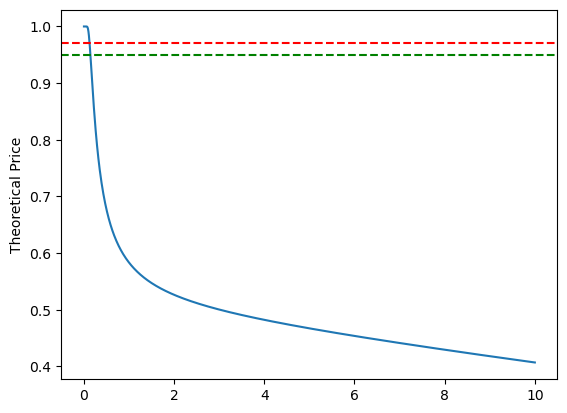

In [106]:
ivs = np.linspace(0, 10, 1000)


bid= 0.95
ask = 0.97

K = 93250 

S = get_brti_price()[1]
tte = hours_until(5, pm=True) 


theoretical_prices = [binary_call_price(S, K, tte, iv, 0) for iv in ivs]

mid_price = (bid + ask) / 2

plt.plot(ivs, theoretical_prices)
plt.axhline(bid, color='green', linestyle='--', label='Bid Price')
plt.axhline(ask, color='red', linestyle='--', label='Ask Price')
plt.ylabel('Theoretical Price')

In [47]:
S = get_brti_price()[1]      # Current BTC price
K = 93500      # Strike
T_hours = hours_until(6, pm=True)    # 4 hours until expiry4

bid = 0.59
ask = 0.60

bid_iv = implied_vol_binary_call(S, K, T_hours, bid)
ask_iv = implied_vol_binary_call(S, K, T_hours, ask)

print("Bid IV:", bid_iv)
print("Ask IV:", ask_iv)

Bid IV: 0.2596185732066506
Ask IV: 0.2312449958802546
